#### Imports

In [ ]:
# Mount Google Drive to access datasets stored in Google Drive
# This is specific to Google Colab environment
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# Navigate to the dataset directory in Google Drive
%cd /gdrive/My Drive/DataSet

Mounted at /gdrive
/gdrive/My Drive/ANN&DL Challenges/DataSet


In [ ]:
# Fix randomness and hide warnings for reproducible results
seed = 42

import os
# Suppress TensorFlow logging messages (only show errors)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Set Python hash seed for deterministic behavior
os.environ['PYTHONHASHSEED'] = str(seed)
# Set matplotlib configuration directory to current working directory
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Suppress warning messages to clean up output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Set numpy random seed for reproducible random number generation
import numpy as np
np.random.seed(seed)

import logging

# Set random seed for Python's built-in random module
import random
random.seed(seed)

In [ ]:
# Import TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
# Import preprocessing function (though it's for MobileNet, not used later)
from keras.applications.mobilenet import preprocess_input

# Configure TensorFlow logging and random seeds for reproducibility
tf.autograph.set_verbosity(0)  # Suppress autograph messages
tf.get_logger().setLevel(logging.ERROR)  # Only show errors
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Legacy logging
tf.random.set_seed(seed)  # Set TensorFlow random seed
tf.compat.v1.set_random_seed(seed)  # Set legacy TensorFlow random seed

# Print TensorFlow version for reference
print(tf.__version__)

2.14.0


In [ ]:
# Import libraries for data manipulation and analysis
import pandas as pd  # Data manipulation and analysis
import cv2  # Computer vision operations (if needed)

# Import visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=16)  # Set default font size for plots
import seaborn as sns  # Statistical data visualization

# Import machine learning utilities
from sklearn.preprocessing import OneHotEncoder  # For categorical encoding
from sklearn.model_selection import train_test_split, KFold  # Data splitting and cross-validation
from sklearn.metrics import mean_squared_error  # Regression metrics
# Import classification metrics for model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

#### Load data

In [ ]:
# Load the balanced dataset from a compressed numpy file
# allow_pickle=True is needed to load arrays containing Python objects
data = np.load('Balanced_data_final.npz', allow_pickle=True)

# Display the keys/arrays available in the loaded file
data.files

['data', 'labels']

In [ ]:
# Extract image data and labels from the loaded dataset
image_data = data['data']    # Image arrays
labels_data = data['labels'] # Corresponding labels

# Print the total number of images in the dataset
print(len(image_data))

6120


In [ ]:
# Analyze the distribution of labels in the dataset
# Find unique values and their counts in the labels
unique, count = np.unique(labels_data, return_counts=True)

# Print unique values and their corresponding sample counts
# This helps understand class balance in the dataset
print('Target labels:',unique)
for i,u in enumerate(unique):
    print(f'{unique[i]} has {count[i]} samples')

Target labels: ['healthy' 'unhealthy']
healthy has 3060 samples
unhealthy has 3060 samples


#### Train, Validation and Test set

In [ ]:
# Split the dataset into training, validation, and test sets
# Use stratified sampling to maintain class distribution across splits

# First split: separate test set (10% of total data)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_data,     # Input samples (images)
    labels_data,    # Target labels
    test_size = 0.1,        # 10% for testing
    random_state=seed,      # For reproducible splits
    stratify = labels_data  # Maintain class proportions
)

# Second split: divide remaining data into training and validation sets
# Validation set size matches test set size for fair comparison
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,    # Remaining 90% of data
    y_train_val,    # Remaining labels
    test_size = len(X_test),    # Ensure validation set size matches test set size
    random_state=seed,          # For reproducible splits
    stratify = y_train_val      # Maintain class proportions
)

#### Inspection

The training set is a 4D array with 4680 elements, where each element is a 96x96 image with 3 color channels. The channel is already included so no need of expanding.

In [ ]:
# Inspect the shapes of training, validation, and test sets
# This helps verify the split was successful and understand data dimensions
print("Training set data and label shape:", X_train.shape, y_train.shape)
print("Validation set data and label shape:", X_val.shape, y_val.shape)
print("Test set data and label shape:", X_test.shape, y_test.shape)

Training set data and label shape: (4896, 96, 96, 3) (4896,)
Validation set data and label shape: (612, 96, 96, 3) (612,)
Test set data and label shape: (612, 96, 96, 3) (612,)


In [ ]:
# Convert string labels to integer labels for binary classification
# 'healthy' -> 0, any other label (presumably 'unhealthy') -> 1
y_train = np.where(y_train == 'healthy',0,1)
y_val = np.where(y_val == 'healthy',0,1)
y_test = np.where(y_test == 'healthy',0,1)

Labels instead must be oved from (x,0) to (x,1)

In [ ]:
# Expand label dimensions from (n,) to (n,1) for compatibility with Keras
# This is required for proper tensor operations and one-hot encoding
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Verify the new shape of labels
print("New labels shape (train, val, test):", y_train.shape, y_val.shape, y_test.shape)

New labels shape (train, val, test): (4896, 1) (612, 1) (612, 1)


In [ ]:
# Verify class distribution across all three sets
# This ensures stratified splitting maintained balanced classes
print('Check occurrences distribution over the 3 sets classes:')
print(pd.DataFrame(y_train, columns=['class'])['class'].value_counts())
print(pd.DataFrame(y_val, columns=['class'])['class'].value_counts())
print(pd.DataFrame(y_test, columns=['class'])['class'].value_counts())

Check occurrences distribution over the 3 sets classes:
0    2448
1    2448
Name: class, dtype: int64
0    306
1    306
Name: class, dtype: int64
1    306
0    306
Name: class, dtype: int64


#### Processing

In [ ]:
# Normalize image data using ConvNeXt-specific preprocessing
# This applies the same normalization used during ConvNeXt training on ImageNet
# Typically scales pixel values and applies mean/std normalization
X_train = tf.keras.applications.convnext.preprocess_input(X_train, data_format=None)
X_val = tf.keras.applications.convnext.preprocess_input(X_val, data_format=None)
X_test = tf.keras.applications.convnext.preprocess_input(X_test, data_format=None)

In [ ]:
# Convert integer labels to one-hot encoded categorical format
# This is required for multi-class classification with categorical crossentropy
# Each label becomes a vector: [1,0] for class 0, [0,1] for class 1
y_train = tfk.utils.to_categorical(y_train, len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val, len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test, len(np.unique(y_test)))

In [ ]:
# Define key model parameters and training hyperparameters
input_shape = X_train.shape[1:]  # Input shape for the model (height, width, channels)
output_shape = y_train.shape[1]  # Output shape for the model (number of classes)
batch_size = 32    # Number of samples processed before model weights are updated
epochs = 200       # Number of complete passes through the training dataset
learning_rate = 1e-4  # Step size for gradient descent optimization

In [ ]:
# Print summary of all model parameters for reference
# This helps track the configuration used for this experiment
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)
print("Learning rate:", learning_rate)

Epochs: 200
Batch Size: 32
Input Shape: (96, 96, 3)
Output Shape: 2
Learning rate: 0.0001


### Build the model

In [ ]:
import keras
from keras import layers

def build_ConvNeXtS(input_shape, seed=seed):
    """
    Build a ConvNeXt Small model for binary classification using transfer learning.
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        seed: Random seed for reproducibility
    
    Returns:
        model: Complete Keras model ready for training
        base_model: Pre-trained ConvNeXt base model for fine-tuning control
    """
    
    # Load pre-trained ConvNeXt Small model from ImageNet
    # Note: Input shape is set to (32,32,3) which differs from input_shape parameter
    # This might need adjustment based on actual image dimensions
    base_model = keras.applications.ConvNeXtSmall(
        weights = "imagenet",        # Use ImageNet pre-trained weights
        input_shape = (32,32,3),     # Expected input shape for ConvNeXt
        include_top = False          # Exclude the final classification layer
    )

    # Define data augmentation pipeline to improve generalization
    # These transformations help the model become more robust to variations
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal_and_vertical", seed=seed),  # Random flipping
            # layers.RandomContrast(0.5, seed=seed),                 # Contrast adjustment (commented out)
            # layers.RandomBrightness(0.1, seed=seed),               # Brightness adjustment (commented out)
            # layers.RandomRotation(0.5, fill_mode="reflect", interpolation="bilinear", seed=seed),  # Rotation (commented out)
            layers.Resizing(32,32,interpolation="lanczos5")          # Resize to match base model input
        ]
    )

    # Initially freeze the pre-trained model to train only the classifier head
    # This prevents destroying pre-trained features during initial training
    base_model.trainable = False

    # Build the complete model architecture
    inputs = keras.Input(shape=input_shape)

    # Apply data augmentation to input images
    x = data_augmentation(inputs)

    # Optional: Add Gaussian noise for regularization (commented out)
    # x = keras.layers.GaussianNoise(0.2,seed=seed)(x)

    # Pass through the frozen base model in inference mode
    # training=False ensures batch normalization layers use learned statistics
    x = base_model(x, training=False)
    
    # Global average pooling to convert feature maps to a single vector
    # This reduces spatial dimensions while preserving important features
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # Optional: Additional dense layers for more complex classification (commented out)
    # x = keras.layers.Dense(4096, activation='relu')(x)
    # x = keras.layers.Dense(1072, activation='relu')(x)
    
    # Dropout layer to prevent overfitting
    x = keras.layers.Dropout(0.2, seed=seed)(x)

    # Final classification layer with 2 units for binary classification
    # No activation function here - will use from_logits=True in loss function
    outputs = keras.layers.Dense(2)(x)
    
    # Create the complete model
    model = keras.Model(inputs, outputs)

    return model, base_model

In [ ]:
# Build the ConvNeXt Small model and display its architecture
# This creates the model instance and shows the layer structure and parameter count
model, base_model = build_ConvNeXtS(input_shape)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 convnext_small (Functional  (None, 1, 1, 768)         49454688  
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 768)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1538

### Train the model

In [ ]:
# Define callback functions to optimize training process
callbacks=[
    # Early stopping: Stop training if validation accuracy doesn't improve for 15 epochs
    # This prevents overfitting and saves computational time
    tfk.callbacks.EarlyStopping(
        monitor='val_binary_accuracy',  # Metric to monitor
        patience=15,                    # Number of epochs to wait for improvement
        restore_best_weights=True,      # Restore weights from best epoch
        mode='max'                      # We want to maximize accuracy
    ),
    # Learning rate reduction: Reduce learning rate when validation accuracy plateaus
    # This helps fine-tune the model when it's close to optimal
    tfk.callbacks.ReduceLROnPlateau(
        monitor="val_binary_accuracy",  # Metric to monitor
        factor=0.1,                     # Factor by which to reduce learning rate
        patience=10,                    # Number of epochs to wait before reducing
        min_lr=1e-5,                    # Minimum learning rate threshold
        mode='max'                      # We want to maximize accuracy
    )
]

In [ ]:
# Compile the model with optimizer, loss function, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(),  # Adam optimizer with default learning rate
    # Binary crossentropy loss for binary classification
    # from_logits=True because final layer has no activation function
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]  # Track binary accuracy during training
)

In [ ]:
# First training phase: Train only the classifier head with frozen base model
# This allows the new classification layers to learn appropriate weights
# before fine-tuning the pre-trained features
epochs = 200

baseline_history = model.fit(
    X_train,                        # Training images
    y_train,                        # Training labels
    validation_data=(X_val,y_val),  # Validation data for monitoring
    epochs=epochs,                  # Maximum number of epochs
    batch_size=batch_size,          # Number of samples per batch
    verbose=1,                      # Print progress during training
    callbacks=callbacks             # Apply early stopping and learning rate reduction
).history

Epoch 1/200
153/153 [==============================] - 28s 102ms/step - loss: 0.7474 - binary_accuracy: 0.5579 - val_loss: 0.6171 - val_binary_accuracy: 0.6348 - lr: 0.0010
Epoch 2/200
153/153 [==============================] - 6s 37ms/step - loss: 0.6649 - binary_accuracy: 0.6104 - val_loss: 0.5943 - val_binary_accuracy: 0.6683 - lr: 0.0010
Epoch 3/200
153/153 [==============================] - 7s 45ms/step - loss: 0.6361 - binary_accuracy: 0.6328 - val_loss: 0.5835 - val_binary_accuracy: 0.6683 - lr: 0.0010
Epoch 4/200
153/153 [==============================] - 6s 37ms/step - loss: 0.6275 - binary_accuracy: 0.6380 - val_loss: 0.5915 - val_binary_accuracy: 0.6487 - lr: 0.0010
Epoch 5/200
153/153 [==============================] - 6s 41ms/step - loss: 0.6227 - binary_accuracy: 0.6376 - val_loss: 0.5755 - val_binary_accuracy: 0.6716 - lr: 0.0010
Epoch 6/200
153/153 [==============================] - 7s 44ms/step - loss: 0.6145 - binary_accuracy: 0.6471 - val_loss: 0.5625 - val_binary_ac

In [ ]:
# Unfreeze the base model to enable fine-tuning
# This allows all layers to be updated during training for better performance
base_model.trainable = True

# Display the model summary to see all trainable parameters
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 convnext_small (Functional  (None, 1, 1, 768)         49454688  
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 768)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1538

In [ ]:
# Recompile the model with a much lower learning rate for fine-tuning
# Lower learning rate prevents destroying pre-trained features during fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate for fine-tuning
    loss=keras.losses.BinaryCrossentropy(from_logits=True),  # Same loss function
    metrics=[keras.metrics.BinaryAccuracy()],  # Same metrics
)

In [ ]:
# Important Note: You should freeze the batch normalization layers during fine-tuning!
# Batch normalization layers should remain frozen to preserve ImageNet statistics
# This is a common best practice in transfer learning to maintain stability

In [ ]:
# Second training phase: Fine-tune the entire model with unfrozen base
# Use fewer epochs and smaller batch size for careful fine-tuning
epochs = 10
batch_size = 32

baseline_history = model.fit(
    X_train,                        # Training images
    y_train,                        # Training labels
    validation_data=(X_val,y_val),  # Validation data
    epochs=epochs,                  # Fewer epochs for fine-tuning
    batch_size=batch_size,          # Same batch size
    verbose=1,                      # Print training progress
    callbacks=callbacks             # Continue using callbacks
).history

Epoch 1/10
153/153 [==============================] - 84s 137ms/step - loss: 0.5756 - binary_accuracy: 0.6808 - val_loss: 0.5232 - val_binary_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 2/10
153/153 [==============================] - 16s 103ms/step - loss: 0.5417 - binary_accuracy: 0.7060 - val_loss: 0.5153 - val_binary_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 3/10
153/153 [==============================] - 16s 105ms/step - loss: 0.5265 - binary_accuracy: 0.7260 - val_loss: 0.5039 - val_binary_accuracy: 0.7443 - lr: 1.0000e-05
Epoch 4/10
153/153 [==============================] - 17s 114ms/step - loss: 0.4915 - binary_accuracy: 0.7474 - val_loss: 0.5027 - val_binary_accuracy: 0.7516 - lr: 1.0000e-05
Epoch 5/10
153/153 [==============================] - 16s 105ms/step - loss: 0.4776 - binary_accuracy: 0.7548 - val_loss: 0.5071 - val_binary_accuracy: 0.7516 - lr: 1.0000e-05
Epoch 6/10
153/153 [==============================] - 16s 104ms/step - loss: 0.4639 - binary_accuracy: 0.7679 - val_loss

In [ ]:
# Check the total number of layers in the base model
# This is useful for understanding model complexity and for selective layer freezing
print(len(base_model.layers))

295


In [ ]:
# Optional: Selective layer freezing approach (currently commented out)
# This code demonstrates how to freeze only the first N layers while allowing
# the deeper layers to be fine-tuned. This can be useful for gradual unfreezing.

# Freeze first 300 layers at a time and retrain
# N = 300
# for i, layer in enumerate(base_model.layers[:N]):
#   layer.trainable=False

# Print layer information to see which layers are trainable
# for i, layer in enumerate(base_model.layers):
#   print(i, layer.name, layer.trainable)
# model.summary()

In [ ]:
# Third training phase: Additional fine-tuning with even fewer epochs
# This provides extra refinement of the model weights
epochs = 5
batch_size = 32

baseline_history = model.fit(
    X_train,                        # Training images
    y_train,                        # Training labels
    validation_data=(X_val,y_val),  # Validation data
    epochs=epochs,                  # Very few epochs for final refinement
    batch_size=batch_size,          # Same batch size
    verbose=1,                      # Print training progress
    callbacks=callbacks             # Continue using callbacks
).history

In [ ]:
# Save the trained model for future use (currently commented out)
# Uncomment this line to save the model after training is complete
#model.save('EfficientNetV2S_New2')

### Performances on the Test Set

In [ ]:
# Generate predictions on the test set to evaluate final model performance

# Optional: Load separate test dataset (currently commented out)
# This code shows how to load a different test set if needed
#datatest = np.load('NewDataSet_test.npz', allow_pickle=True)
#X_test = datatest['data']
#y_test = datatest['labels']
#y_test = np.expand_dims(y_test, axis=-1)
#print("New labels shape (test):", y_test.shape)

# Generate predictions for the entire test set
# verbose=0 suppresses progress output during prediction
predictions = model.predict(X_test, verbose=0)

# Display the shape of predictions to verify output format
print("Predictions Shape:", predictions.shape)

Predictions Shape: (612, 2)


In [ ]:
# Display the raw prediction outputs
# These are logits (unnormalized probabilities) for each class
# Shape should be (n_samples, 2) for binary classification
predictions

In [ ]:
# Optional: Convert logits to class predictions (currently commented out)
# This would convert the logit outputs to discrete class predictions (0 or 1)
# by taking the argmax along the class dimension
#predictions = tf.argmax(predictions, axis=-1)
#predictions

In [ ]:
# Optional: Delete the model to free up memory (currently commented out)
# Uncomment this line if you need to free up GPU/RAM memory after training
# del model

Accuracy: 0.732
Precision: 0.7321
Recall: 0.732
F1: 0.732


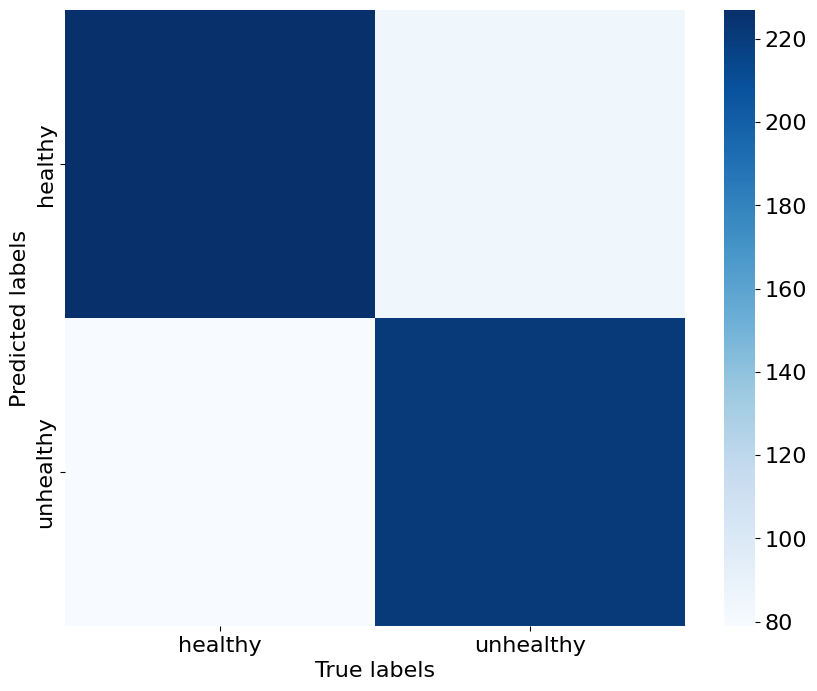

In [ ]:
# Calculate comprehensive evaluation metrics and visualize results

# Convert one-hot encoded labels and predictions to class indices for metric calculation
# np.argmax finds the index of the maximum value (predicted/true class)
true_labels = np.argmax(y_test, axis=-1)      # Convert one-hot to class indices
pred_labels = np.argmax(predictions, axis=-1)  # Convert logits to class indices

# Compute the confusion matrix to understand classification errors
cm = confusion_matrix(true_labels, pred_labels)

# Calculate key classification metrics
accuracy = accuracy_score(true_labels, pred_labels)  # Overall correctness
precision = precision_score(true_labels, pred_labels, average='macro')  # Precision per class, averaged
recall = recall_score(true_labels, pred_labels, average='macro')     # Recall per class, averaged
f1 = f1_score(true_labels, pred_labels, average='macro')             # F1-score per class, averaged

# Display the computed metrics with 4 decimal precision
print('Accuracy:', accuracy.round(4))      # Fraction of correct predictions
print('Precision:', precision.round(4))    # True positives / (True positives + False positives)
print('Recall:', recall.round(4))          # True positives / (True positives + False negatives)
print('F1:', f1.round(4))                  # Harmonic mean of precision and recall

# Create a visualization of the confusion matrix
plt.figure(figsize=(10, 8))
labels = {0:'healthy', 1:'unhealthy'}  # Define class labels for display

# Create heatmap of confusion matrix
# .T transposes the matrix for conventional display (predicted on y-axis, true on x-axis)
sns.heatmap(cm.T, 
           xticklabels=list(labels.values()),  # True class labels on x-axis
           yticklabels=list(labels.values()),  # Predicted class labels on y-axis
           cmap='Blues')                       # Blue color scheme

plt.xlabel('True labels')      # Label for x-axis
plt.ylabel('Predicted labels') # Label for y-axis
plt.show()                     # Display the plot